In [119]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# Если переменная BASE_DIR не определена, то устанавливаем её как текущий каталог
if not 'BASE_DIR' in locals():
    BASE_DIR = os.path.abspath(os.curdir)

In [120]:
# Если текущий каталог является BASE_DIR, то переходим на уровень выше
if os.path.abspath(os.curdir) == BASE_DIR:
    os.chdir('../')

# Определяем путь к каталогу с данными
dirname = os.path.abspath(os.curdir) + r'\data'

# Читаем данные из CSV файла
df = pd.read_csv(path.join(os.sep, dirname, 'Annual snowfall in Chicago 1939 to 1978.csv'))

# Оставляем только колонку 'x'
df = df['x']
df.head()

0    33.9
1    31.0
2    52.5
3    29.8
4    45.2
Name: x, dtype: float64

In [121]:
df.describe()

count    40.000000
mean     41.442500
std      15.714584
min      14.300000
25%      30.700000
50%      38.000000
75%      52.275000
max      82.300000
Name: x, dtype: float64

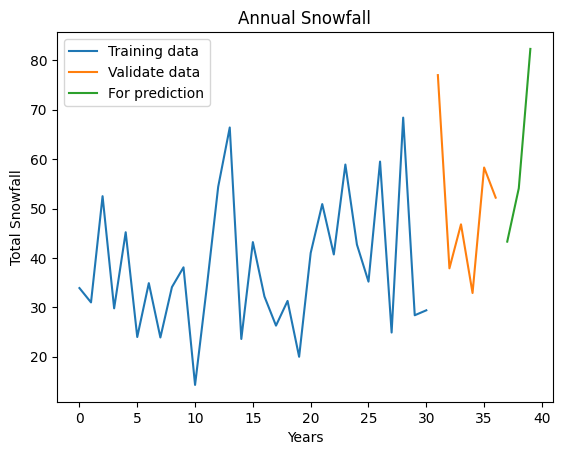

In [122]:
# Определяем размеры выборок
ln = len(df)
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# Делим данные на обучающую, валидационную и тестовую выборки
train_df = df[df.index<= train_cutoff]
validate_df = df[(df.index> train_cutoff) & (df.index<= validate_cutoff)]
forecast_df = df[df.index> validate_cutoff]

# Выводим график данных
plt.plot(train_df.index, train_df, label='Training data')
plt.plot(validate_df.index, validate_df, label='Validate data')
plt.plot(forecast_df.index, forecast_df, label='For prediction')
plt.legend()
plt.title('Annual Snowfall')
plt.ylabel('Total Snowfall')
plt.xlabel('Years')
plt.show()

In [123]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def create_features(data, lag_range, rolling_range):
    """
    Создает признаки на основе лагов и скользящих статистик.

    Параметры:
    data: исходный временной ряд
    lag_range: диапазон лагов для создания признаков
    rolling_range: диапазон скользящих окон для создания признаков
    """
    # Создаем DataFrame для хранения признаков
    features = pd.DataFrame(index=data.index)

    # Создаем признаки на основе лагов
    for lag in lag_range:
        features[f'lag_{lag}'] = data.shift(lag)

    # Создаем признаки на основе скользящих статистик
    for window in rolling_range:
        features[f'rolling_mean_{window}'] = data.rolling(window=window).mean()
        features[f'rolling_std_{window}'] = data.rolling(window=window).std()

    return features

# Определяем диапазоны лагов и скользящих окон
lag_range = range(1, 4)
rolling_range = range(2, 5)

# Создаем признаки
features = create_features(df, lag_range, rolling_range)

# Удаляем строки с пропущенными значениями
features.dropna(inplace=True)

# Разделяем данные на обучающую и тестовую выборки
train_features = features[features.index <= train_cutoff]
validate_features = features[(features.index > train_cutoff) & (features.index <= validate_cutoff)]

# Обучаем модели дерева решений и случайного леса на новых признаках
tree_model = DecisionTreeRegressor()
tree_model.fit(train_features, train_df.loc[train_features.index])
forest_model = RandomForestRegressor()
forest_model.fit(train_features, train_df.loc[train_features.index])

# Предсказываем значения на тестовом наборе данных
tree_predictions = tree_model.predict(validate_features)
forest_predictions = forest_model.predict(validate_features)


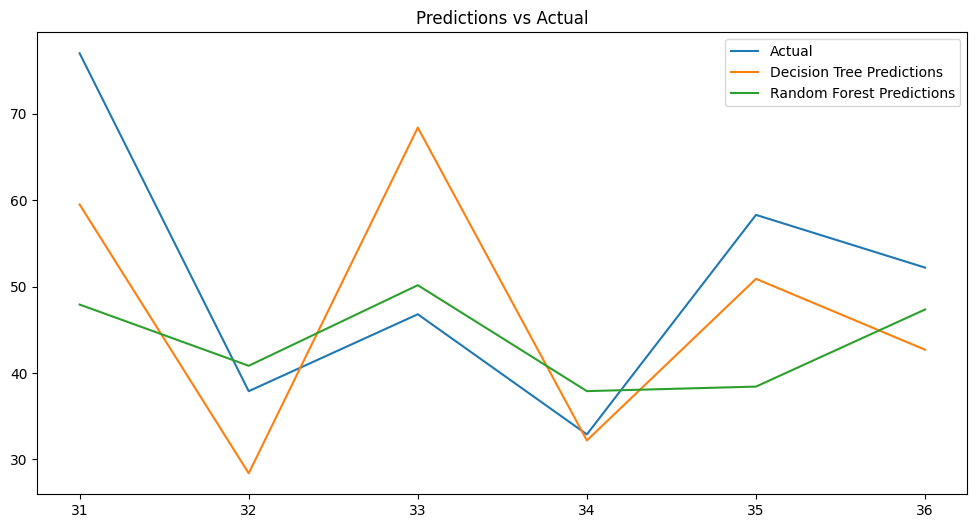

In [124]:
# График предсказаний дерева решений и случайного леса
plt.figure(figsize=(12,6))
plt.plot(validate_df.index, validate_df, label='Actual')
plt.plot(validate_df.index, tree_predictions, label='Decision Tree Predictions')
plt.plot(validate_df.index, forest_predictions, label='Random Forest Predictions')
plt.legend()
plt.title('Predictions vs Actual')
plt.show()

In [125]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Оцениваем метрики
print("Decision Tree")
print("RMSE:", np.sqrt(mean_squared_error(validate_df, tree_predictions)))
print("MAPE:", mean_absolute_percentage_error(validate_df, tree_predictions))
print("MAE:", mean_absolute_error(validate_df, tree_predictions))
print("SMAPE:", smape(validate_df, tree_predictions))
print("R2: ", r2_score(validate_df, tree_predictions))

print("Random Forest")
print("RMSE:", np.sqrt(mean_squared_error(validate_df, forest_predictions)))
print("MAPE:", mean_absolute_percentage_error(validate_df, forest_predictions))
print("MAE:", mean_absolute_error(validate_df, forest_predictions))
print("R2: ", r2_score(validate_df, forest_predictions))
print("SMAPE:", smape(validate_df, forest_predictions))

Decision Tree
RMSE: 12.965081308396542
MAPE: 0.21161157107116105
MAE: 11.033333333333333
SMAPE: 21.253894756175697
R2:  0.191505906024666
Random Forest
RMSE: 14.769546844774894
MAPE: 0.18548296934320804
MAE: 10.850666666666664
R2:  -0.04920585031123359
SMAPE: 20.9864568256053


In [126]:
from sklearn.ensemble import IsolationForest

# Обучаем модель изолированного дерева
iso_forest = IsolationForest(contamination=0.1)
iso_forest.fit(df.values.reshape(-1, 1))

# Предсказываем выбросы
outliers = iso_forest.predict(df.values.reshape(-1, 1))

# Выводим индексы выбросов
outlier_indices = df.index[outliers == -1]
print("Outlier indices:", outlier_indices)

Outlier indices: Index([10, 28, 31, 39], dtype='int64')


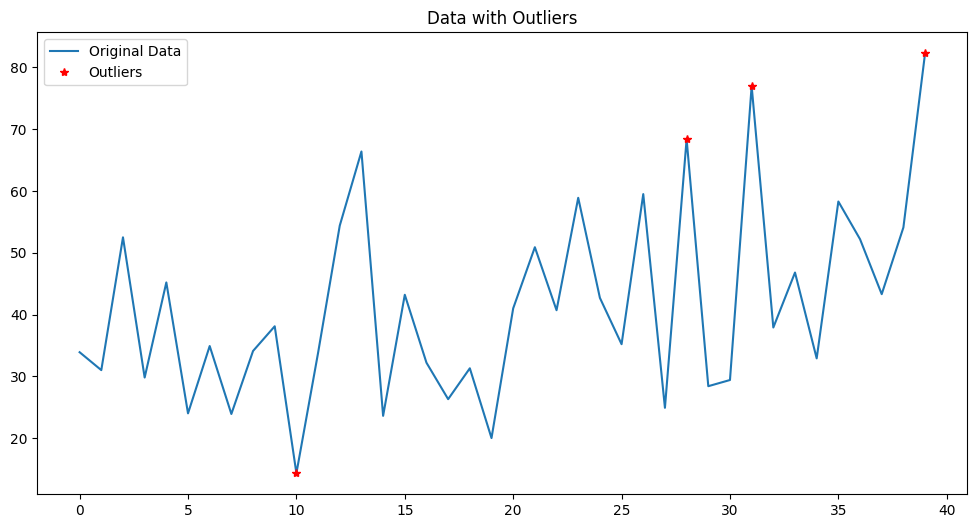

In [127]:
# График данных с выбросами
plt.figure(figsize=(12,6))
plt.plot(df, label='Original Data')
plt.plot(outlier_indices, df[outlier_indices], 'r*', label='Outliers')
plt.legend()
plt.title('Data with Outliers')
plt.show()